# Necessary imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Loading dataset

In [4]:
# 'parse_dates=True' converts index to a datetime object

df = pd.read_csv('Alocohol_sales_dataset.csv',index_col=0,parse_dates=True)
len(df)

354

In [5]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [6]:
df.tail()

,S4248SM144NCEN
DATE,
2021-02-01,12473
2021-03-01,15330
2021-04-01,15622
2021-05-01,15499
2021-06-01,17787


In [7]:
df.columns

Index(['S4248SM144NCEN'], dtype='object')

# Plot the Time series

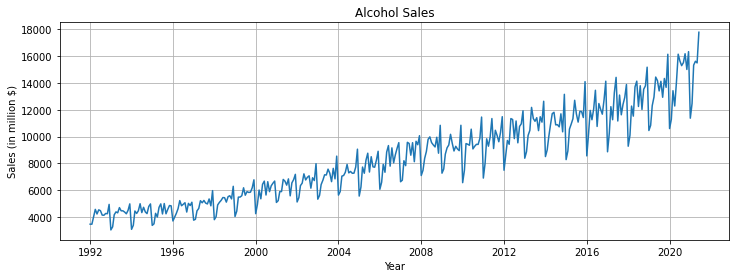

In [8]:
plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.xlabel('Year')
plt.ylabel('Sales (in million $)')
plt.grid(True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

# Splitting the data---> train_data and test_data

In [9]:
y = df['S4248SM144NCEN'].values.astype(float)

# We want to predict the values for 12 months i.e 1 year 
test_size = 12

train_data = y[:-test_size]
test_data = y[-test_size:]

In [10]:
test_data

array([15646., 15293., 15516., 16182., 15009., 16339., 11371., 12473.,
       15330., 15622., 15499., 17787.])

# Normalize the data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))

train_norm = scaler.fit_transform(train_data.reshape(-1,1))

In [12]:
train_norm.max()

1.0000000000000002

In [13]:
train_norm.min()

-1.0

In [14]:
train_norm.mean()

-0.2244721551299094

# Preparing the data for lstm

In [15]:
train_norm.shape

(342, 1)

In [16]:
train_norm = torch.FloatTensor(train_norm).view(-1)

In [17]:
train_norm.type

<function Tensor.type>

In [18]:
train_norm.shape

torch.Size([342])

In [19]:
# [(12 data values, 1 label),........]

window_size = 12


def input_data(data,ws): 
    out = []
    L = len(data)
    for i in range(L-ws):
        window = data[i:i+ws]
        label = data[i+ws:i+ws+1]
        out.append((window,label))
    return out

 

In [20]:
train_data = input_data(train_norm,window_size)
len(train_data) 

330

In [21]:
train_data[0]

(tensor([-0.9347, -0.9349, -0.8520, -0.7663, -0.8186, -0.7716, -0.7812, -0.8314,
         -0.8331, -0.8128, -0.8157, -0.7096]),
 tensor([-1.]))

# Model

In [22]:
class LSTMmodel(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # lstm layer
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # fully connected layer
        self.linear = nn.Linear(hidden_size,output_size)
        
        # h0 and co
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  #returns the last value i.e the prediction

In [23]:
torch.zeros(1,1,10)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [24]:
torch.manual_seed(33)
model = LSTMmodel()

# Mean square loss
criterion = nn.MSELoss()

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMmodel(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

# Training

In [26]:
no_of_epochs = 100

import time
start_time = time.time()

for epoch in range(no_of_epochs):
    
    
    for seq, y_train in train_data:
        
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.22121434
Epoch:  2 Loss: 0.22936697
Epoch:  3 Loss: 0.28425357
Epoch:  4 Loss: 0.23603044
Epoch:  5 Loss: 0.21165350
Epoch:  6 Loss: 0.20822527
Epoch:  7 Loss: 0.19842725
Epoch:  8 Loss: 0.19544175
Epoch:  9 Loss: 0.18719219
Epoch: 10 Loss: 0.18379393
Epoch: 11 Loss: 0.18306695
Epoch: 12 Loss: 0.17481753
Epoch: 13 Loss: 0.16951025
Epoch: 14 Loss: 0.15574117
Epoch: 15 Loss: 0.14506695
Epoch: 16 Loss: 0.13128944
Epoch: 17 Loss: 0.12240069
Epoch: 18 Loss: 0.10672185
Epoch: 19 Loss: 0.04343938
Epoch: 20 Loss: 0.04157595
Epoch: 21 Loss: 0.03979015
Epoch: 22 Loss: 0.04126154
Epoch: 23 Loss: 0.09246331
Epoch: 24 Loss: 0.12452261
Epoch: 25 Loss: 0.07145411
Epoch: 26 Loss: 0.05336626
Epoch: 27 Loss: 0.09666783
Epoch: 28 Loss: 0.10095172
Epoch: 29 Loss: 0.10301547
Epoch: 30 Loss: 0.09969787
Epoch: 31 Loss: 0.09805971
Epoch: 32 Loss: 0.10412923
Epoch: 33 Loss: 0.11185015
Epoch: 34 Loss: 0.11252914
Epoch: 35 Loss: 0.12053851
Epoch: 36 Loss: 0.12405263
Epoch: 37 Loss: 0.12181991
E

# Predict and compare to test data

In [27]:
future = 12

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [28]:
preds[window_size:]

[0.4622509777545929,
 0.8221768140792847,
 0.8361123204231262,
 0.6724929809570312,
 0.7217718362808228,
 0.9485397338867188,
 0.22052645683288574,
 0.6806027293205261,
 0.5911152958869934,
 0.5450988411903381,
 0.7598956227302551,
 0.8853204846382141]

# Invert Normalization and check predictions with true values

In [29]:
# Model predictions

true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[12621.90416309],
       [14982.65772355],
       [15074.06070966],
       [14000.8814621 ],
       [14324.10147417],
       [15811.47211456],
       [11036.43303037],
       [14054.07330161],
       [13467.12522572],
       [13165.30329937],
       [14574.15538949],
       [15396.81705874]])

In [30]:
# Actual values in the csv file

df['S4248SM144NCEN'][-12:]

DATE
2020-07-01    15646
2020-08-01    15293
2020-09-01    15516
2020-10-01    16182
2020-11-01    15009
2020-12-01    16339
2021-01-01    11371
2021-02-01    12473
2021-03-01    15330
2021-04-01    15622
2021-05-01    15499
2021-06-01    17787
Name: S4248SM144NCEN, dtype: int64

# Plotting

In [34]:
x = np.arange('2020-07-01', '2021-07-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
       '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
       '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01'],
      dtype='datetime64[D]')

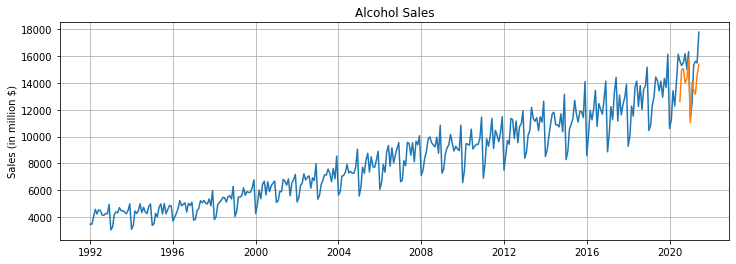

In [35]:
plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (in million $)')
plt.grid(True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

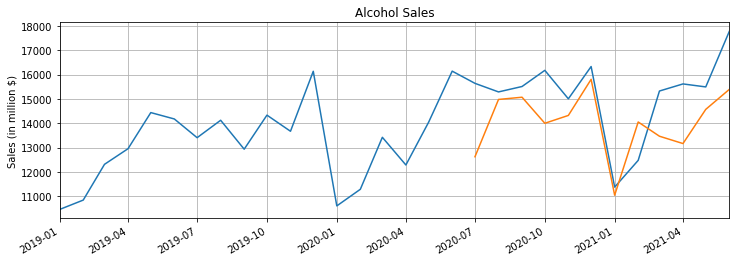

In [36]:
# Zoomed in plot

fig = plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (in million $)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()


plt.plot(df['S4248SM144NCEN']['2019-01-01':])
plt.plot(x,true_predictions)
plt.show()

# Forecast into future (Getting future predictions for next 1 year)

In [37]:
#Training again with all the data

epochs = 100


model.train()


y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    
    for seq, y_train in all_data:  
        
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.02772857
Epoch:  2 Loss: 0.00444781
Epoch:  3 Loss: 0.00809343
Epoch:  4 Loss: 0.00028751
Epoch:  5 Loss: 0.00000003
Epoch:  6 Loss: 0.00009746
Epoch:  7 Loss: 0.00024263
Epoch:  8 Loss: 0.00030789
Epoch:  9 Loss: 0.00024206
Epoch: 10 Loss: 0.00066148
Epoch: 11 Loss: 0.00030238
Epoch: 12 Loss: 0.00009949
Epoch: 13 Loss: 0.00011764
Epoch: 14 Loss: 0.00001785
Epoch: 15 Loss: 0.00206230
Epoch: 16 Loss: 0.00000755
Epoch: 17 Loss: 0.00305159
Epoch: 18 Loss: 0.00151892
Epoch: 19 Loss: 0.00245968
Epoch: 20 Loss: 0.00028799
Epoch: 21 Loss: 0.00746970
Epoch: 22 Loss: 0.00337798
Epoch: 23 Loss: 0.00014648
Epoch: 24 Loss: 0.00040291
Epoch: 25 Loss: 0.00025034
Epoch: 26 Loss: 0.00149347
Epoch: 27 Loss: 0.00020475
Epoch: 28 Loss: 0.00626977
Epoch: 29 Loss: 0.00956939
Epoch: 30 Loss: 0.00053679
Epoch: 31 Loss: 0.01996719
Epoch: 32 Loss: 0.00008541
Epoch: 33 Loss: 0.00055210
Epoch: 34 Loss: 0.00000322
Epoch: 35 Loss: 0.00087586
Epoch: 36 Loss: 0.00199722
Epoch: 37 Loss: 0.01025679
E

# Predicting (Yellow curve denotes the future 1 year of predictions)

In [38]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
       
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())



In [39]:
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

x = np.arange('2021-07-01', '2022-07-01', dtype='datetime64[M]').astype('datetime64[D]')

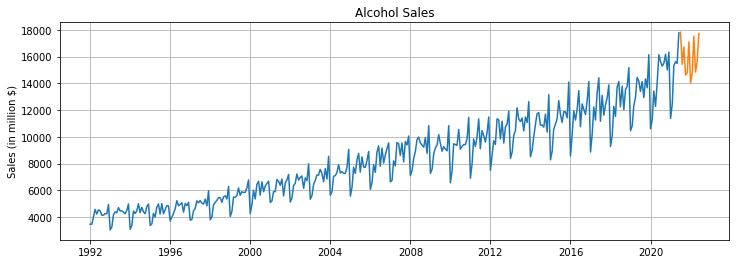

In [40]:
plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (in million $)')
plt.grid(True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

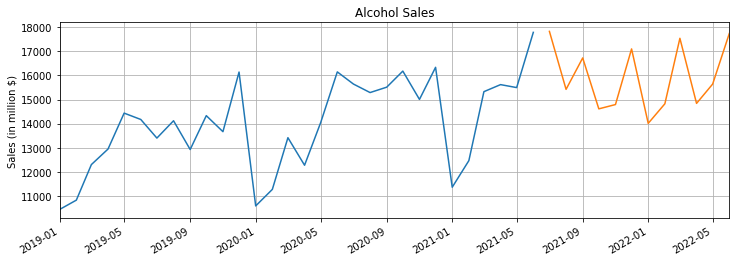

In [41]:
#Zoomed in plot

fig = plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (in million $)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2019-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()